# Getting Started: Market Research
This Jupyter notebook is a quick demonstration on how to get started on the market research section.

## 1) Download Data
Please download the train and test data and place it within the ./research/data path. If you've placed it in the correct place, you should see the following cell work:

In [2]:
import pandas as pd

train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

train_data.set_index("time", inplace=True)
test_data.set_index("time", inplace=True)

print(train_data.head())
print(test_data.head())

             A         B         C         D         E         F         G  \
time                                                                         
0     0.207366 -0.159951 -0.634176 -0.580962 -0.266505  0.060173 -0.475257   
1     0.188828 -0.265508  0.042143 -0.550442 -0.132319 -0.185219  0.028295   
2    -0.144261 -0.577142 -0.214634 -0.747391 -0.184255 -0.464831 -0.085181   
3     0.208982 -0.310449  0.513708 -0.562868  0.742308 -0.305487  0.762246   
4     0.093320 -0.358156  0.173188 -0.687296 -0.161461 -0.116062 -0.245748   

             H         I         J         K         L         M         N  \
time                                                                         
0    -1.486516 -0.332594 -0.671466 -0.226149 -0.187624 -0.780237 -0.785965   
1     0.093210 -0.518139 -0.251917 -0.347845 -0.359069 -0.161254  0.020401   
2     0.700449 -0.603438  0.197773 -0.566696 -0.580799  0.202726  0.135261   
3     1.363020 -0.384575  0.525556 -0.348514 -0.428099  0.54899

## 2) Investigate the Dataset
In the datasets, you're given columns of time and A through N, each of which represent some sort of real-life market quantity. In the train dataset, you're also given Y1 and Y2, real-life market quantities you'd like to predict in terms of time and A through N. You're not given Y1 and Y2 in the test set, because this is what you're being asked to predict.

Let's do some exploration of the relationships of A - N and Y1. In particular, let's look at the relationship between C and Y1:

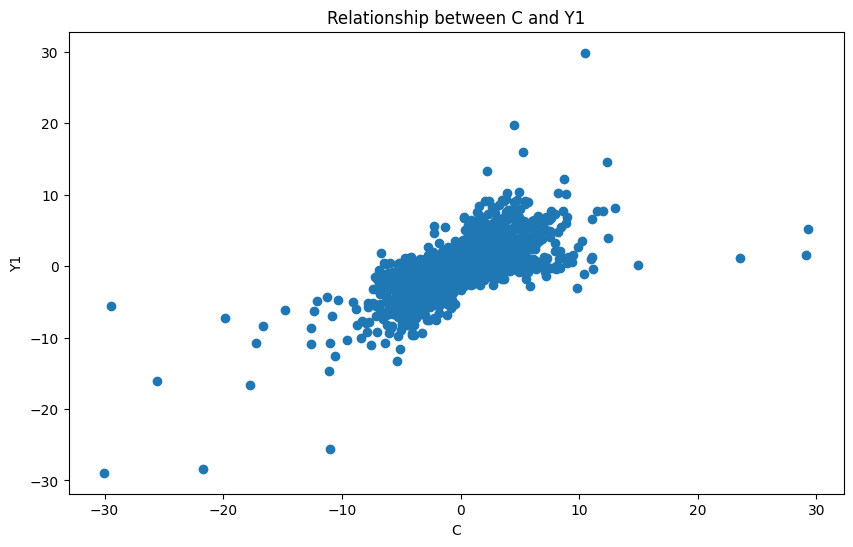

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(train_data['C'], train_data['Y1'])
plt.xlabel('C')
plt.ylabel('Y1')
plt.title('Relationship between C and Y1')
plt.show()

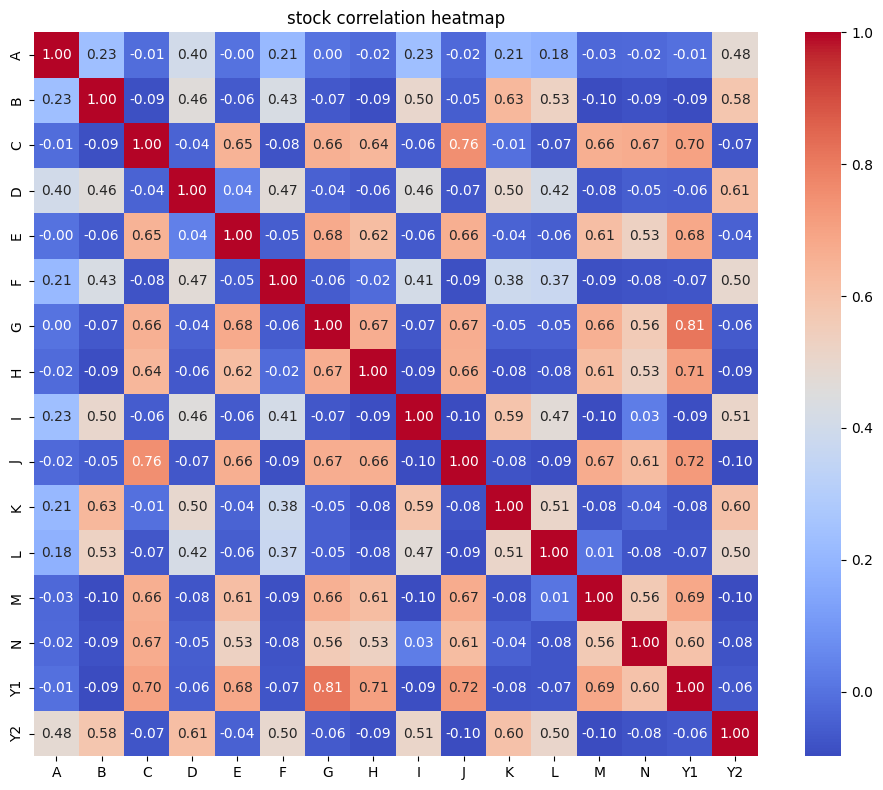

In [4]:
import seaborn as sns

corr = train_data.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap="coolwarm", square=True)
plt.title("stock correlation heatmap")
plt.tight_layout()
plt.show()


In [5]:
target = ["Y1", "Y2"]
features = [col for col in train_data.columns if col not in target]

print(f"{target = }")
print(f"{features = }")

# corr2 = train_data[features + target].corr()[target]
# sns.heatmap(corr2, annot=True, fmt='.2f', cmap="coolwarm")
# plt.title("corr 2")
# plt.show()

target = ['Y1', 'Y2']
features = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N']


In [6]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# import numpy as np

# from sklearn.model_selection import TimeSeriesSplit


X = train_data[features]
Y = train_data[target]



# tscv = TimeSeriesSplit(n_splits=3)

# for train_idx,test_idx in tscv.split(X):
#     print(Y.iloc[test_idx])
# vif = pd.DataFrame()
# vif["Feature"] = X.columns
# vif["VIF"] = [variance_inflation_factor(X.values,i) for i in range(len(X.columns))]

# print(vif)

# # not multicolinear, so don't need to rm columns

In [7]:
# from sklearn.feature_selection import mutual_info_regression

# m1 = mutual_info_regression(X,train_data["Y1"])
# m2 = mutual_info_regression(X,train_data["Y2"])



# pd.DataFrame({"M1_Y1" : m1, "M2" : m2}, index=X.columns)

In [8]:
# from statsmodels.tsa.stattools import adfuller

# Y1 = adfuller(train_data["Y1"])
# Y2 = adfuller(train_data["Y2"])

# print(Y1,Y2)

In [9]:
# C E G H J M N highly correlated to Y1
# A B D F I K L highly correlated to Y2

In [20]:
from typing import Any, Dict
import numpy as np
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import  ElasticNet

Y1_FEATURES = ['C', 'E', 'G', 'H', 'J', 'M', 'N']
Y2_FEATURES = ['A', 'B', 'D', 'F', 'I', 'K', 'L']


def custom_metric(y_true,y_pred):
    if hasattr(y_true,"values"):
        y_true = y_true.values
    if hasattr(y_pred,"values"):
        y_pred = y_pred.values
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    r2_y1 = r2_score(y_true[:,0],y_pred[:,0])
    r2_y2 = r2_score(y_true[:,1],y_pred[:,1])
    
    return (r2_y1 + r2_y2 ) / 2

def tune_model(X,Y,n_trials=30,n_splits=3) -> Dict[str, Any]:
    X_arr = X.values if hasattr(X, 'values') else X
    Y_arr = Y.values if hasattr(Y, 'values') else Y
    
    def objective(trial: optuna.Trial) -> float:
        alpha=trial.suggest_float("alpha",1e-5,30, log=True)
        l1_ratio = trial.suggest_float("l1_ratio",0.0,1.0)
        
        
        model = ElasticNet(
            alpha=alpha,
            l1_ratio=l1_ratio,
            max_iter=10000
        )
     
        tscv = TimeSeriesSplit(n_splits=n_splits)
        
        res = []
        for train_idx, test_idx in tscv.split(X_arr):
            
            X_train,X_val = X_arr[train_idx].copy(), X_arr[test_idx].copy()
            y_train,y_val = Y_arr[train_idx].copy(), Y_arr[test_idx].copy()
            
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            
        
            model.fit(X_train_scaled,y_train)
            y_pred = model.predict(X_val_scaled)
            res.append(r2_score(y_pred=y_pred,y_true=y_val))

        
        return np.mean(res)
            
        
        
    study = optuna.create_study(
            direction="maximize",
            sampler=optuna.samplers.TPESampler(seed=42),
            pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
        )
    study.optimize(
        objective,
        n_trials=n_trials,
        gc_after_trial=True,
        show_progress_bar=True,
        n_jobs=1,
    )
    
    return study.best_params



def tune_separated_model(X,Y,n_trials=30,n_splits=3):

    
    y1_params = tune_model(
                                X[Y1_FEATURES],
                                Y["Y1"],
                                n_trials=n_trials,
                                n_splits=n_splits
                                )
    y2_params = tune_model(
                                X[Y2_FEATURES],
                                Y[['Y2']],
                                n_trials=n_trials,
                                n_splits=n_splits
                            )
    
    return {
        "Y1" : y1_params,
        "Y2" : y2_params
    }

In [ ]:
n: int = len(test_data)
split_idx = int(0.8 * n)
X_train,X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = Y.iloc[:split_idx], Y.iloc[split_idx:]

best_params = tune_separated_model(X_train,y_train,n_trials=100,n_splits=3)

scaler_y1 = StandardScaler()
X_train_y1 = scaler_y1.fit_transform(X_train[Y1_FEATURES])
model_y1 = ElasticNet(**best_params["Y1"]).fit(X_train_y1,y_train["Y1"])


scaler_y2 = StandardScaler()
X_train_y2 = scaler_y2.fit_transform(X_train[Y2_FEATURES])
model_y2 = ElasticNet(**best_params["Y2"]).fit(X_train_y2,y_train["Y2"])


y1_pred = model_y1.predict(scaler_y1.transform(X_test[Y1_FEATURES]))
y2_pred = model_y2.predict(scaler_y2.transform(X_test[Y2_FEATURES]))

preds = pd.DataFrame({'Y1': y1_pred, 'Y2': y2_pred}, index=X_test.index)




[I 2025-09-21 10:09:29,550] A new study created in memory with name: no-name-9fdd0395-bd62-4c38-863d-58f36234161f


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-09-21 10:09:29,600] Trial 0 finished with value: 0.8213799769215506 and parameters: {'alpha': 0.002666501083759804, 'l1_ratio': 0.9507143064099162}. Best is trial 0 with value: 0.8213799769215506.
[I 2025-09-21 10:09:29,797] Trial 1 finished with value: 0.5824436161490972 and parameters: {'alpha': 0.5510785649903659, 'l1_ratio': 0.5986584841970366}. Best is trial 0 with value: 0.8213799769215506.
[I 2025-09-21 10:09:29,937] Trial 2 finished with value: 0.8215037468913594 and parameters: {'alpha': 0.00010245936315222363, 'l1_ratio': 0.15599452033620265}. Best is trial 2 with value: 0.8215037468913594.
[I 2025-09-21 10:09:30,084] Trial 3 finished with value: 0.8214950031007021 and parameters: {'alpha': 2.3780150503717896e-05, 'l1_ratio': 0.8661761457749352}. Best is trial 2 with value: 0.8215037468913594.
[I 2025-09-21 10:09:30,205] Trial 4 finished with value: 0.8138906484940192 and parameters: {'alpha': 0.07825188699683218, 'l1_ratio': 0.7080725777960455}. Best is trial 2 with 

[I 2025-09-21 10:09:42,130] A new study created in memory with name: no-name-3796fea4-1e4f-4784-8175-519b158ab067


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-09-21 10:09:42,175] Trial 0 finished with value: 0.5667320270181649 and parameters: {'alpha': 0.002666501083759804, 'l1_ratio': 0.9507143064099162}. Best is trial 0 with value: 0.5667320270181649.
[I 2025-09-21 10:09:42,331] Trial 1 finished with value: 0.42120111211265826 and parameters: {'alpha': 0.5510785649903659, 'l1_ratio': 0.5986584841970366}. Best is trial 0 with value: 0.5667320270181649.
[I 2025-09-21 10:09:42,454] Trial 2 finished with value: 0.5667383921526895 and parameters: {'alpha': 0.00010245936315222363, 'l1_ratio': 0.15599452033620265}. Best is trial 2 with value: 0.5667383921526895.
[I 2025-09-21 10:09:42,588] Trial 3 finished with value: 0.5666984361490178 and parameters: {'alpha': 2.3780150503717896e-05, 'l1_ratio': 0.8661761457749352}. Best is trial 2 with value: 0.5667383921526895.
[I 2025-09-21 10:09:42,700] Trial 4 finished with value: 0.5709958333248661 and parameters: {'alpha': 0.07825188699683218, 'l1_ratio': 0.7080725777960455}. Best is trial 4 with

In [29]:
print(f"Competition Score: {custom_metric(y_test, preds):.4f}")



Competition Score: 0.6203


In [ ]:
real_test_y1 = test_data.drop(columns=["id"])[Y1_FEATURES]
real_test_y2 = test_data.drop(columns=["id"])[Y2_FEATURES]



scaler_y1.transform(real_test_y1)
scaler_y2.transform(real_test_y2)



y1_pred = model_y1.predict(real_test_y1)

y2_pred = model_y2.predict(real_test_y2)

result = pd.DataFrame({
    "id" : test_data["id"],
    "Y1" : y1_pred,
    "Y2" : y2_pred
})

print(result)

# result.to_csv('preds.csv', index=False)



          id        Y1        Y2
time                            
80005      1  0.387883 -0.269757
80006      2 -0.159549 -0.351404
80007      3 -0.144878 -0.214552
80008      4 -0.336245 -0.000455
80009      5 -0.807678 -0.102447
...      ...       ...       ...
95996  15992 -0.206779 -0.297139
95997  15993 -0.142678 -0.405367
95998  15994  0.225752 -0.312374
95999  15995  0.262191 -0.208471
96000  15996  0.254571 -0.353277

[15996 rows x 3 columns]


/home/Bruh/.conda/envs/algotrade/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(
/home/Bruh/.conda/envs/algotrade/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(


- high corr only for particular columns
- method: split the dataset and train model separately for each of the output
- relationship is likely to be linear, as mutual_info show that they are similar, and it is not higher than the correlation

In [ ]:
# Calculate correlation between C and Y1
correlation = train_data['C'].corr(train_data['Y1'])
print(f"Correlation between C and Y1: {correlation:.4f}")

Correlation between C and Y1: 0.7038


Clearly there's a strong relationship between C and Y1. You should definitely use C to predict Y1!

## 3) Submit Predictions
In order to submit predictions, we need to make a CSV file with three columns: id, Y1, and Y2. In the below example, we let our predictions of Y1 and Y2 be the means of Y1 and Y2 in the train set.

In [ ]:
preds = test_data[['id']]
preds['Y1'] = train_data['Y1'].mean()
preds['Y2'] = train_data['Y2'].mean()
preds

/tmp/ipykernel_36109/2816426628.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['Y1'] = train_data['Y1'].mean()
/tmp/ipykernel_36109/2816426628.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['Y2'] = train_data['Y2'].mean()


,id,Y1,Y2
time,,,
80005,1,-0.002807,-0.061172
80006,2,-0.002807,-0.061172
80007,3,-0.002807,-0.061172
80008,4,-0.002807,-0.061172
80009,5,-0.002807,-0.061172
...,...,...,...
95996,15992,-0.002807,-0.061172
95997,15993,-0.002807,-0.061172
95998,15994,-0.002807,-0.061172


In [ ]:
# save preds to csv
preds.to_csv('preds.csv', index=False)

You should now be able to submit preds.csv to [https://quantchallenge.org/dashboard/data/upload-predictions](https://quantchallenge.org/dashboard/data/upload-predictions)! Note that you should receive a public $R^2$ score of $-0.042456$ with this set of predictions. You should try to get the highest possible $R^2$ score over the course of these next few days. Be careful of overfitting to the public score, which is only calculated on a subset of the test data—the final score that counts is the private $R^2$ score!